In [2]:
from __future__ import print_function
import torch
from GIM_encoder import GIM_Encoder
from data import get_dataloader
from decoder_architectures import SimpleV2Decoder
from helper_functions import create_log_dir, fft_magnitude, plot_two_graphs_side_by_side
from options_interpolate import get_options
from IPython.display import Audio
import numpy as np
import soundfile as sf

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import random

In [3]:
def load_classifier(options, model_path, device):
    n_features = 32
    n_classes = 3
    include_bias = False
    classifier = torch.nn.Sequential(torch.nn.Linear(n_features, n_classes, bias=include_bias))
    classifier = classifier.to(device)
    classifier.load_state_dict(torch.load( model_path, map_location=device))

    return classifier

def setup():
  OPTIONS = get_options()
  DEVICE = OPTIONS["device"]

  # CPC_MODEL_PATH = OPTIONS["cpc_model_path"] 
  # ENCODER = GIM_Encoder(OPTIONS, path=CPC_MODEL_PATH)
  # ENCODER.encoder.eval()

  CLASSIFIER_PATH = r"D:\thesis_logs\logs\good models\temporary vowel classifier/model_199.pt"
  classifier = load_classifier(OPTIONS, CLASSIFIER_PATH, DEVICE)
  classifier.eval()

  train_loader, _, test_loader, _ = get_dataloader.get_dataloader(
      OPTIONS, dataset="de_boer_sounds_reshuffledv2", split_and_pad=False, train_noise=False, shuffle=True)

  return OPTIONS, DEVICE, None, classifier

OPTIONS, DEVICE, ENCODER, CLASSIFIER = setup()

Loading De Boer Sounds dataset...


In [4]:
CLASSIFIER

# get weights

CLASSIFIER[0].weight.detach().cpu().numpy()[0]

array([ 0.90322393, -0.03523955, -0.03045569, -0.07067342, -0.00298624,
       -0.02036572, -0.31106645,  0.0147479 , -0.0254695 , -0.08130652,
       -0.503284  ,  0.07562408, -0.0679691 , -0.08970449,  0.775402  ,
        0.37090385,  1.02752   , -0.11030471, -0.8958366 ,  0.00668732,
       -0.6594699 , -0.16343434, -0.04577669, -0.19667208, -0.03056322,
       -0.6542675 ,  0.80934095, -0.05094348, -0.06194502,  0.45320496,
        0.06726978, -0.61999106], dtype=float32)

In [5]:
weights = np.array([CLASSIFIER[0].weight.detach().cpu().numpy()[0], CLASSIFIER[0].weight.detach().cpu().numpy()[1], CLASSIFIER[0].weight.detach().cpu().numpy()[2]])
print(weights) # 3 x 32
print(weights.shape)
print(weights.min())
print(weights.max())

[[ 9.03223932e-01 -3.52395475e-02 -3.04556880e-02 -7.06734210e-02
  -2.98623811e-03 -2.03657169e-02 -3.11066449e-01  1.47478972e-02
  -2.54694987e-02 -8.13065171e-02 -5.03283978e-01  7.56240785e-02
  -6.79690987e-02 -8.97044912e-02  7.75402009e-01  3.70903850e-01
   1.02751994e+00 -1.10304706e-01 -8.95836592e-01  6.68732170e-03
  -6.59469903e-01 -1.63434342e-01 -4.57766913e-02 -1.96672082e-01
  -3.05632222e-02 -6.54267490e-01  8.09340954e-01 -5.09434752e-02
  -6.19450174e-02  4.53204960e-01  6.72697797e-02 -6.19991064e-01]
 [-3.17077994e-01 -1.03221172e-02  1.22941472e-01  1.51551202e-01
   8.76180008e-02  8.06289837e-02  8.06747377e-01  1.34133622e-01
   1.55048385e-01 -9.71063133e-03  4.64093089e-01  1.47515565e-01
   1.11348189e-01  1.12115256e-01 -5.71653903e-01 -2.90503681e-01
  -1.29722381e+00  9.73050743e-02  4.83276486e-01  1.65467605e-01
   5.95574319e-01  2.03123204e-02 -3.38889100e-02 -4.94377688e-02
   1.33284722e-02 -4.99754995e-02 -5.30035555e-01 -1.00304438e-02
   1.0809

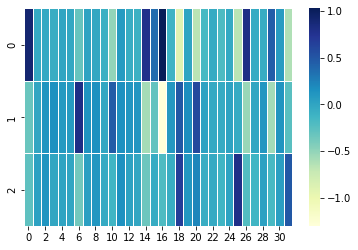

In [6]:
# create heathmap of weights

import seaborn as sns
import pandas as pd

df = pd.DataFrame(weights)
df

ax = sns.heatmap(df, linewidth=0.5, cmap="YlGnBu")


In [7]:
def rescale_between_neg1_and_1(x):
  # values are currently between -1.5 and 1.5 so we rescale to -1 and 1
  absolute = np.abs(x)
  print(absolute.max())
  return x / absolute.max()


1.0


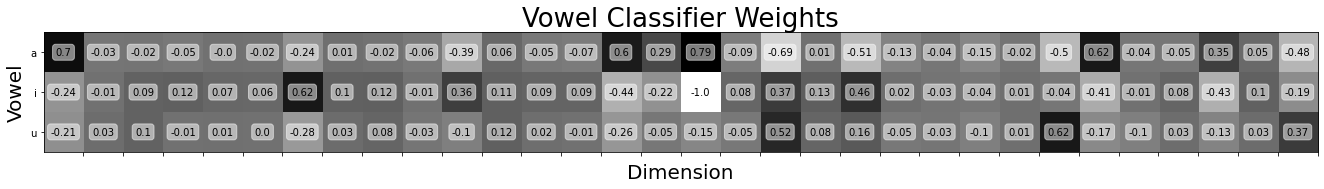

In [17]:
# heatmap using matplotlib

# normalise weights to be between -1 and 1
weights = rescale_between_neg1_and_1(weights)


import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(weights, cmap="binary")
# template options: https://matplotlib.org/stable/gallery/color/colormap_reference.html


# "a" if number == 0,  "i" if number == 1 else "u"

# We want to show all ticks...
ax.set_xticks(np.arange(len(weights[0])))
ax.set_yticks(np.arange(len(weights)))
# ... and label them with the respective list entries
ax.set_xticklabels(np.arange(len(weights[0])))
# ax.set_yticklabels(np.arange(len(weights)))
# set y tick labels to be the vowels
ax.set_yticklabels(["a", "i", "u"])

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), 
         rotation_mode="anchor"
         )

# # Loop over data dimensions and create text annotations.
for i in range(len(weights)):
    for j in range(len(weights[0])):
        text = ax.text(j, i, round(weights[i, j], 2), # bold=True, fontsize=14,
                       ha="center", va="center", color="black",
                        bbox=dict(boxstyle="round", facecolor="white", edgecolor="white" , alpha=0.5)) # transparent edge color
                        # color options: https://matplotlib.org/stable/gallery/color/named_colors.html

# change size
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()

ax.set_title("Vowel Classifier Weights")
fig.tight_layout()

# title size
ax.title.set_size(26)


# x, y labels
ax.set_xlabel("Dimension", fontsize=20)
ax.set_ylabel("Vowel", fontsize=20)

# tight layout
fig.tight_layout()

# save as pdf
plt.savefig("vowel_classifier_weights.pdf")


plt.show()


In [8]:
CLASSIFIER = torch.nn.Sequential(CLASSIFIER, torch.nn.Softmax(dim=1))

In [75]:
# CLASSIFIER[0].weight.detach().cpu().numpy()[1]
# append softmax layer


x = torch.randn(1, 32)
x = x.to(DEVICE)
CLASSIFIER(x)


t = 100
min, max = -2, 2
range = np.linspace(min, max, t)
z = torch.zeros((1, 32)).to(DEVICE)

#data = np.array([])
data = np.zeros((t, t, 3))
for i, val_i in enumerate(range):
  for j, val_j in enumerate(range):
    z[0][0] = val_i
    z[0][16] = val_j

    prediction = CLASSIFIER(z).detach().cpu().numpy()
    data[i][j] = prediction[0]

# data

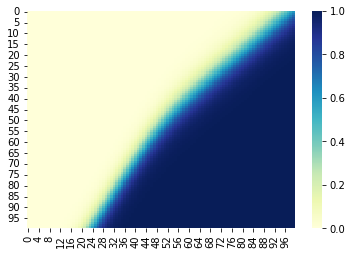

In [65]:
# a
df = pd.DataFrame(data[:,:,0])
ax = sns.heatmap(df, cmap="YlGnBu")

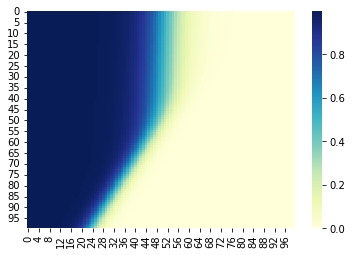

In [66]:
# i
df = pd.DataFrame(data[:,:,1])
ax = sns.heatmap(df, cmap="YlGnBu")

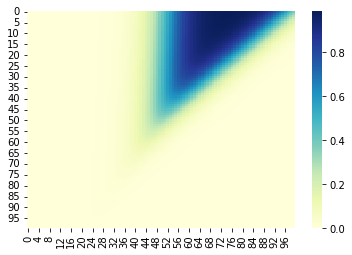

In [67]:
# u
df = pd.DataFrame(data[:,:,2])
ax = sns.heatmap(df, cmap="YlGnBu")

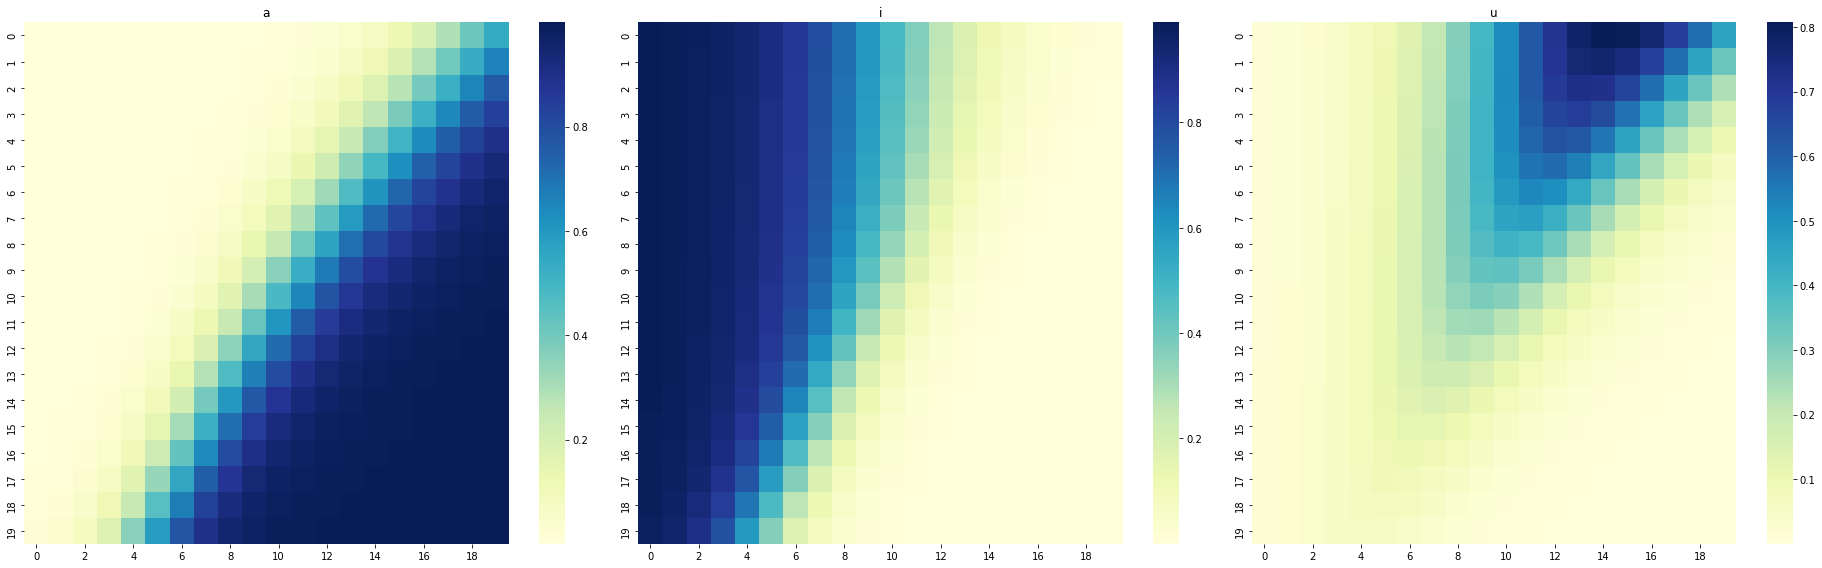

In [54]:
# Plot the three graphs side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# a
df = pd.DataFrame(data[:,:,0])
ax = sns.heatmap(df, cmap="YlGnBu", ax=axs[0])
ax.set_title("a")

# i
df = pd.DataFrame(data[:,:,1])
ax = sns.heatmap(df, cmap="YlGnBu", ax=axs[1])
ax.set_title("i")

# u
df = pd.DataFrame(data[:,:,2])
ax = sns.heatmap(df, cmap="YlGnBu", ax=axs[2])
ax.set_title("u")


# change size
fig.set_size_inches(26, 8)
fig.tight_layout()


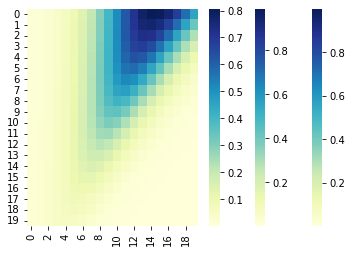

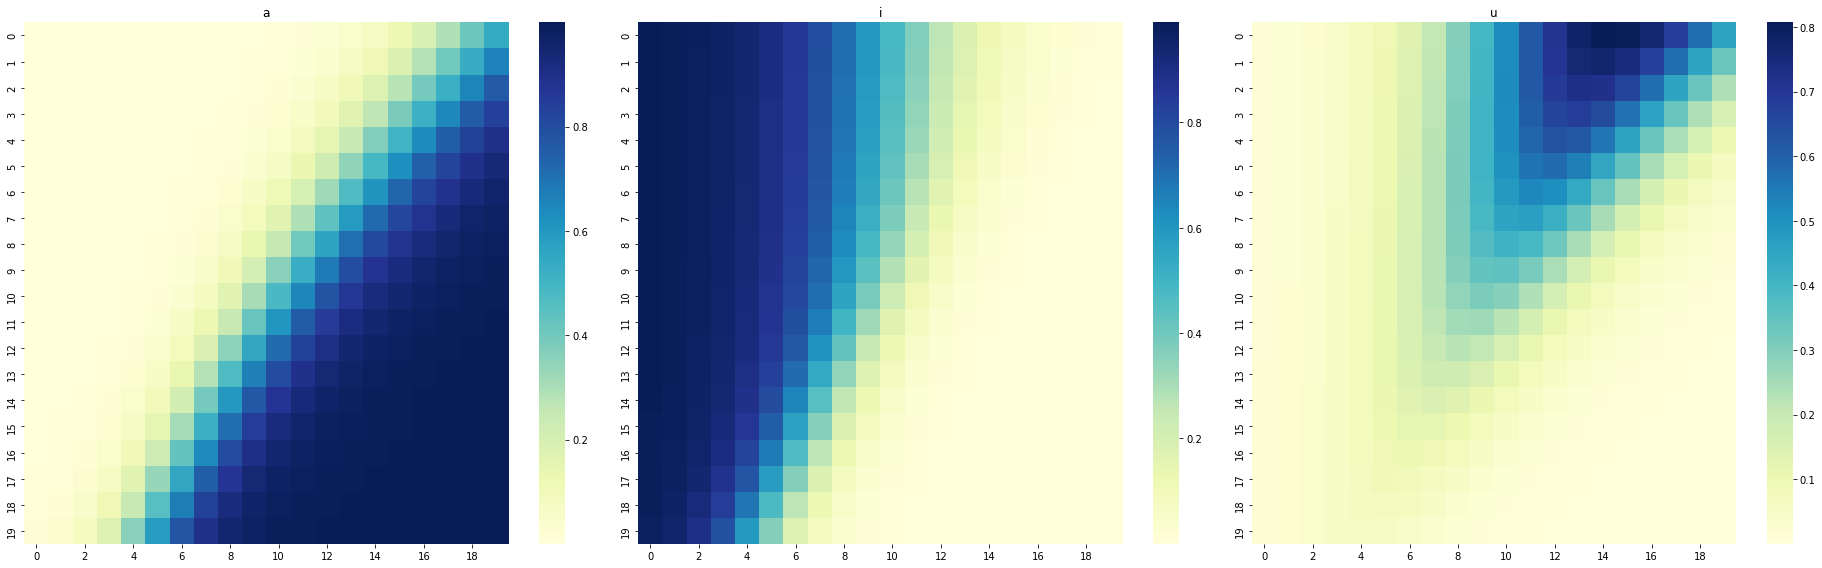

In [57]:
def plot_single_graph_showing_probability_of_vowel_with_highest_probabil(data):
  # data is of shape: t x t x 3
  # we want to plot 3 heathmaps, one for each vowel. The values in the heatmap will be the probability of that vowel

  # a
  df = pd.DataFrame(data[:,:,0])
  ax = sns.heatmap(df, cmap="YlGnBu")

  # i
  df = pd.DataFrame(data[:,:,1])
  ax = sns.heatmap(df, cmap="YlGnBu")

  # u
  df = pd.DataFrame(data[:,:,2])
  ax = sns.heatmap(df, cmap="YlGnBu")

  # Plot the three graphs side by side
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))

  # a
  df = pd.DataFrame(data[:,:,0])
  ax = sns.heatmap(df, cmap="YlGnBu", ax=axs[0])
  ax.set_title("a")

  # i
  df = pd.DataFrame(data[:,:,1])
  ax = sns.heatmap(df, cmap="YlGnBu", ax=axs[1])
  ax.set_title("i")

  # u
  df = pd.DataFrame(data[:,:,2])
  ax = sns.heatmap(df, cmap="YlGnBu", ax=axs[2])
  ax.set_title("u")


  # change size
  fig.set_size_inches(26, 8)
  fig.tight_layout()

  plt.show()

plot_single_graph_showing_probability_of_vowel_with_highest_probabil(data)

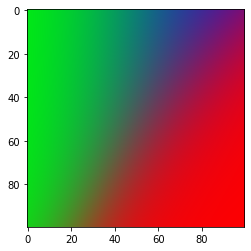

In [76]:
# # Plot the heatmap
fig, ax = plt.subplots()
im = ax.imshow(data, cmap="YlGnBu")

# x and y ticks are the values between `min` and `max`
# ax.set_xticks(np.arange(len(range)))
# ax.set_yticks(np.arange(len(range)))
# round to 2 decimals
# ax.set_xticklabels(np.round(range, 2))
# ax.set_yticklabels(np.round(range, 2))


# # ... and label them with the respective list entries
# ax.set_xticklabels(np.round(range, 2))
# ax.set_yticklabels(np.round(range, 2))

# # limit the number of ticks
# ax.xaxis.set_major_locator(plt.MaxNLocator(10))
# ax.yaxis.set_major_locator(plt.MaxNLocator(10))



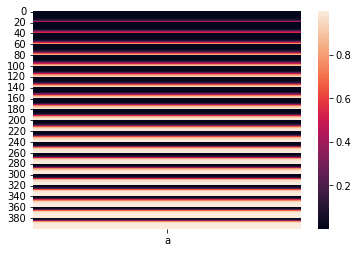

In [58]:
# Plot the heatmap using seaborn
import seaborn as sns
import pandas as pd

# the following line gives error: ValueError: Must pass 2-d input. shape=(20, 20, 3)
# df = pd.DataFrame(data, columns=["a", "i", "u"])

# solution:

# reshape data to be 2d
data_2d = data.reshape(t*t, 3)
data_2d = data_2d[:, 0] # only take first column

df = pd.DataFrame(data_2d, columns=["a"])


ax = sns.heatmap(df)





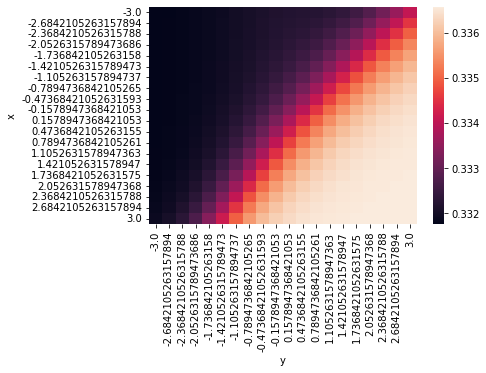

In [31]:
# data = data.reshape((t*t, -1))

# df = pd.DataFrame(data, columns=["x", "y", "a", "i", "u"])
# # create a heathmap of df
# df

# df = df.pivot(index="x", columns="y", values="a")

# ax = sns.heatmap(df)

# # round x and y axis labels
# # x_axis_labels = np.linspace(min, max, t)
# # x_axis_labels = np.round(x_axis_labels, 3)

# # y_axis_labels = np.linspace(min, max, t)
# # y_axis_labels = np.round(y_axis_labels, 3)

# # ax.set_xticklabels(x_axis_labels)
# # ax.set_yticklabels(y_axis_labels)




In [38]:
# data[:5, :]
data.shape

(400, 5)

In [34]:
df

y,-3.000000,-2.684211,-2.368421,-2.052632,-1.736842,-1.421053,-1.105263,-0.789474,-0.473684,-0.157895,0.157895,0.473684,0.789474,1.105263,1.421053,1.736842,2.052632,2.368421,2.684211,3.000000
x,,,,,,,,,,,,,,,,,,,,
-3.000000,0.331756,0.331775,0.331799,0.331832,0.331874,0.331925,0.331985,0.332048,0.332109,0.332158,0.332193,0.332215,0.332239,0.332287,0.332382,0.332548,0.332803,0.333151,0.333584,0.334069
-2.684211,0.331757,0.331775,0.331801,0.331834,0.331876,0.331929,0.331989,0.332055,0.332119,0.332174,0.332218,0.332256,0.332308,0.332397,0.332550,0.332790,0.333128,0.333553,0.334038,0.334536
-2.368421,0.331758,0.331776,0.331802,0.331836,0.331879,0.331933,0.331995,0.332064,0.332132,0.332195,0.332253,0.332316,0.332405,0.332549,0.332776,0.333100,0.333519,0.334002,0.334504,0.334976
-2.052632,0.331758,0.331777,0.331803,0.331838,0.331882,0.331937,0.332003,0.332075,0.332151,0.332227,0.332305,0.332401,0.332542,0.332757,0.333068,0.333478,0.333959,0.334466,0.334945,0.335360
-1.736842,0.331759,0.331779,0.331805,0.331840,0.331886,0.331944,0.332013,0.332092,0.332178,0.332271,0.332379,0.332521,0.332729,0.333028,0.333428,0.333908,0.334420,0.334909,0.335334,0.335676
-1.421053,0.331760,0.331780,0.331807,0.331843,0.331891,0.331952,0.332026,0.332114,0.332215,0.332334,0.332483,0.332687,0.332977,0.333368,0.333845,0.334364,0.334864,0.335302,0.335655,0.335924
-1.105263,0.331761,0.331781,0.331809,0.331847,0.331897,0.331962,0.332044,0.332145,0.332269,0.332423,0.332628,0.332911,0.333293,0.333768,0.334294,0.334810,0.335263,0.335629,0.335908,0.336112
-0.789474,0.331762,0.331783,0.331812,0.331852,0.331906,0.331977,0.332070,0.332190,0.332344,0.332549,0.332826,0.333200,0.333672,0.334208,0.334741,0.335214,0.335597,0.335888,0.336099,0.336249
-0.473684,0.331763,0.331785,0.331816,0.331858,0.331917,0.331997,0.332106,0.332253,0.332451,0.332721,0.333086,0.333555,0.334099,0.334654,0.335152,0.335556,0.335863,0.336084,0.336240,0.336349


In [ ]:
print(data.shape)
print(data)
